# Test Binning

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed
import pandas as pd
from sklearn.metrics import auc
import matplotlib
import random

# Bug Fixing

In [32]:
problem_regions = set([
    "chr8_25402079-25402692.npy",
    "chr8_25400686-25401414.npy",
    "chr18_14614837-14615417.npy",
    "chr4_135051533-135052045.npy",
    "chr15_27348617-27349198.npy",
    "chr7_1142401-1144866.npy",
    "chr7_151782043-151782443.npy",
    "chr12_8402962-8403388.npy",
    "chr1_37640513-37642567.npy",
    "chr16_84401461-84401863.npy",
    "chr20_34665376-34666969.npy"
])

NUM_HASHES = 1000

"""
Class for loading all signature matrices and generating an ROC curve as the band size varies.
"""
class signatureMtxs():
    def __init__(self):
        self.signature_mtxs = []

    """
    Load into memory all signature matrices
    """
    def load(self, directory, local_problem_regions = problem_regions, include_length = 0):
        if type(include_length) is int:
            self.include_length = 0
            self.threshold = 0
        else:
            self.include_length = include_length[0]
            self.threshold = include_length[1]

        for file in os.listdir(directory):
            if file in local_problem_regions: continue
            self.signature_mtxs.append(
                np.load( os.path.join(directory,file) )
            )

    def loadMatrix(self, path):
        self.signature_mtxs.append(np.load(path))

    """
    Use banding technique to bin reads by similarity
    """
    def band(self, band_length, matrix_range = None):
        counts = [0 for _ in range(4)]
        if type(matrix_range) is type(range(1)):
            matrix_iterable = self.signature_mtxs[min(matrix_range):max(matrix_range)]
        else:
            matrix_iterable = self.signature_mtxs
        for matrix in matrix_iterable:
            labels = matrix[0,:].astype('int8')
            signature_matrix = matrix[1:,:]
            for i, count in enumerate(
                self.tprSignatureMatrix(signature_matrix, band_length, labels, wantAdjacencyMatrix = False)
            ):
                counts[i] += count
        return counts

    """
    Generate TPR and FPR for a given signature matrix, band length, and label list
    Returns [test_pos, tot_pos, test_neg, tot_neg]
    """
    def tprSignatureMatrix(self, signature_matrix, band_length, labels, wantAdjacencyMatrix = False):
        def connectBucket(bucket, adjacencyMatrix):
            for i in range(len(bucket)-1):
                for j in range(i+1, len(bucket)):
                    # Include length filtering at this step
                    # TODO this code will actually break lol
                    if self.include_length == 1 and (abs(len(i) - len(j)) > self.threshold): continue
                    if self.include_length == 2 and ( (len(i) - len(j)) / max(len(i), len(j)) > self.threshold): continue
                    

                    adjacencyMatrix[bucket[i],bucket[j]] = True
                    adjacencyMatrix[bucket[j],bucket[i]] = True
            return adjacencyMatrix

        firstOcc = np.argmax(labels>1)
        adjacencyMatrix = np.zeros((len(labels), len(labels)))

        for i in range(signature_matrix.shape[0]//band_length):
            buckets = defaultdict(list[int])
            startBucket = i*band_length
            endBucket = (i+1)*band_length
            for j in range(signature_matrix.shape[1]):
                buckets[signature_matrix[startBucket:endBucket, j].tobytes()].append(j)
            for bucket in buckets.values():
                adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)

        if wantAdjacencyMatrix:
            return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix), adjacencyMatrix

        return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix)

    def tpr_fpr(self, n, firstOcc, adjacencyMatrix):
        trueMask = np.zeros((n , n), dtype = bool)
        trueMask[:firstOcc, :firstOcc] = 1
        trueMask[firstOcc:, firstOcc:] = 1

        true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
        tot_pos = int((np.sum(trueMask) - n)/2)
        false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
        tot_neg = int(np.sum(~trueMask)/2)

        return true_pos, tot_pos, false_pos, tot_neg

"""
Load class with correct input matrices
"""
def loadFilter(path, include_length):
    if path == "euclidean":
        filter_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,21,1,1"
    elif path == "sketch":
        filter_dir = "../../../output/signatureMtxs_20bp/sketch/1000,21,1"
    elif path == "minHash":
        filter_dir = "../../../output/signatureMtxs_20bp/minHash/1000,21,1"
    else:
        filter_dir = path

    filter_test = signatureMtxs()
    start_time = time.time()
    filter_test.load(filter_dir, include_length = include_length)
    load_time = time.time()
    return filter_test, load_time - start_time

"""
Call band function on filters. Needed so we can parallelize
"""
def bandFunction(filter_test, band_size, matrix_range = None):
    output = filter_test.band(band_size, matrix_range)
    return output

"""
Parallelize calling band function on all band sizes and regions
"""
def bandTest(filter_test, band_sizes = range(1,200), matrix_range = None):
    inputs = zip(repeat(filter_test), band_sizes, repeat(matrix_range))
    num_cores = multiprocessing.cpu_count()

    print("Running Parallel Step")
    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=0)(delayed(bandFunction)(i, j, k) for i, j, k  in inputs)
    end = time.time()
    print("Compute Time:\t", end-start)
    
    tprs = []
    fprs = []
    for a, b, c, d in outputs:
        tprs.append(a/b)
        fprs.append(c/d)
    return outputs, band_sizes, tprs, fprs

"""
Calls object generations, loading, and testing functions
"""
def filterBandTests(path, band_sizes = range(1,200), matrix_range = None, include_length = 0):
    print(path)
    filter_test, load_time = loadFilter(path, include_length)
    print("Load Time:\t", round(load_time, 2))

    outputs, band_sizes, tprs, fprs = bandTest(filter_test, band_sizes = band_sizes, matrix_range = matrix_range)

    return outputs, band_sizes, tprs, fprs

"""
Wraps caller function to return data in pandas dataframe for ease of use
"""
def dataToPandas(filter_type, read_in = True, band_sizes = range(1,200), matrix_range = None, include_length = 0):
    output_path = "../../../output/analysis"
    save_path = os.path.join(output_path, f"{filter_type}.tsv")

    if read_in:
        try:
            df = pd.read_csv(save_path, sep="\t")
            return df
        except:
            print(f"File not found {save_path}")
            print("Running Band Tests")
    print("Running Tests")
    band_test_output = filterBandTests(filter_type, band_sizes=band_sizes, matrix_range = matrix_range, include_length = include_length)
    outputs, bands, tprs, fprs = band_test_output
    found_pos, max_pos, found_err, max_err = zip(*outputs)
    columns = {
        "found_pos": found_pos,
        "max_pos":max_pos,
        "found_err":found_err,
        "max_err":max_err,
        "band_sizes":bands,
        "tpr":tprs,
        "fpr":fprs
    }
    print("Generating Data Frame")
    df = pd.DataFrame.from_dict(columns)
    df.to_csv(save_path, sep="\t", index=False, header=True)

    return df


## Run Filters

## Plot ROC Curve

In [21]:
"""
Plot the ROC curve
"""
def plotROC(df, title = "ROC Curve"):
    bands = df["band_sizes"]
    tprs = df["tpr"]
    fprs = df["fpr"]

    #area_under_curve = auc(fprs, tprs)

    # Plot the ROC curve
    fig, ax = plt.subplots()

    plt.scatter(fprs, tprs, c = bands, marker = ".")
    num_labels = min(10, len(bands))
    scale = int(len(bands)//num_labels)
    for i in range(num_labels):
        index = i*scale
        ax.text(fprs[index], tprs[index]+0.05, bands[index])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "lower right")

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


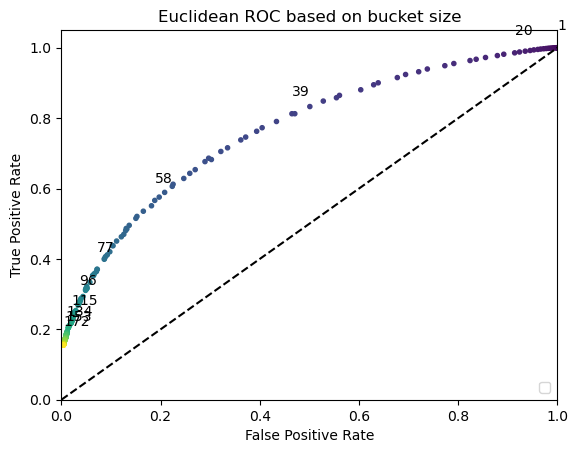

In [22]:
title = "Euclidean ROC based on bucket size"
plotROC(euclidean_df, title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


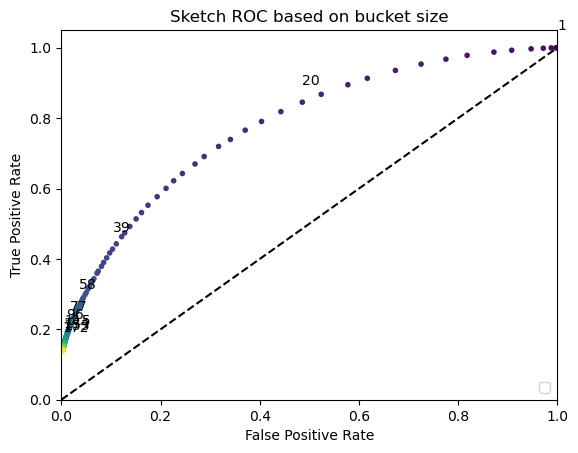

In [23]:
title = "Sketch ROC based on bucket size"
plotROC(sketch_df, title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


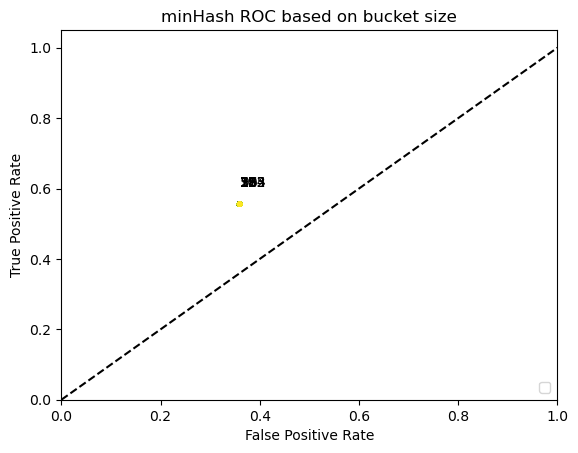

In [24]:
title = "minHash ROC based on bucket size"
plotROC(minHash_df, title)

### Why is minHash all stacked in one place?


This is really confusing for me. I'm using the exact same code for all three groups so there shouldn't be any problems in how we are counting tpr and fprs. The only difference is the signature matrices that I'm loading in correspond to the minHash output as opposed to the others. But when analyzing the matrices below they don't all look the same or have overly large groups of patterns. I'm really confused how to even diagnose further.

I will test the minHash filter on a smaller set and take a look at the results directly, from computing the TPR/FPR on small samples and see if this holds from the test_filters script.

This is really confusing me.

In [9]:
def show_problems(matrix):
    total_dif = 0
    n = matrix.shape[1]
    difs = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            dif = sum(matrix[:,i] - matrix[:,j])
            if dif == 0 and not np.all(matrix[:,i] == matrix[:,j]):
                print("Weirdness reads:", i, j)
            difs[i][j] = dif
            total_dif += abs(dif)
    print(total_dif)

    vmin = np.min(difs)
    vmax = np.max(difs)
    print(vmin, vmax)
    plt.imshow(difs, cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label('Value')
    plt.show()

In [10]:
minHash_dir = "/data/wford/sv_merge/output/signatureMtxs/minHash/1000,20,40"
minHash_test = signatureMtxs()
minHash_test.load(minHash_dir)

52312.0
-1000.0 1000.0


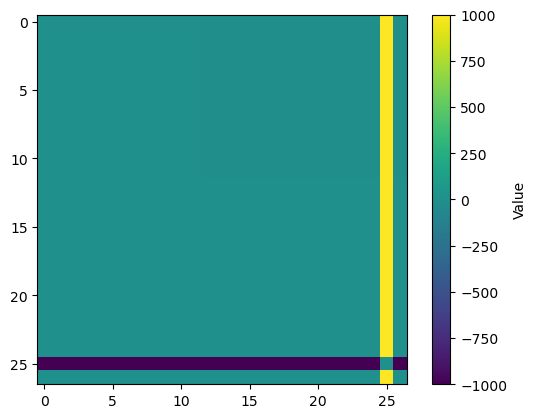

156.0
-1.0 1.0


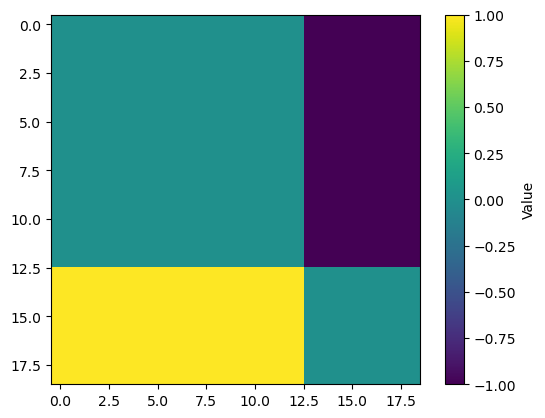

90.0
-1.0 1.0


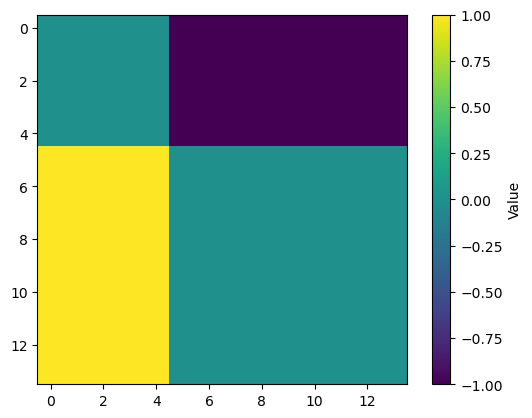

38150.0
-1001.0 1001.0


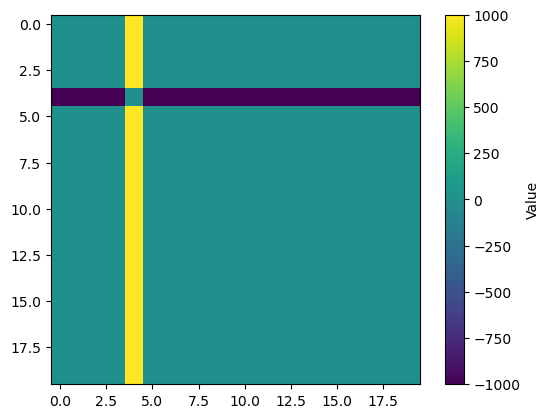

242.0
-1.0 1.0


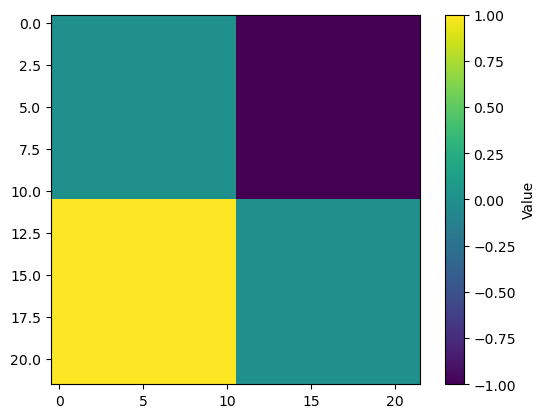

120.0
-1.0 1.0


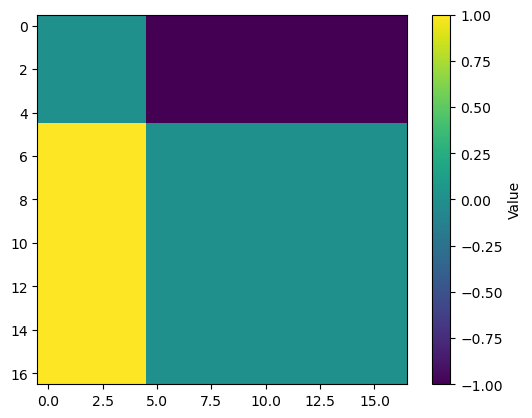

988182.0
-26001.0 26001.0


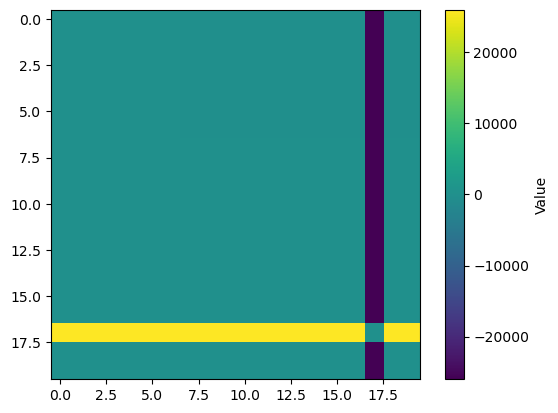

1760236.0
-11001.0 11001.0


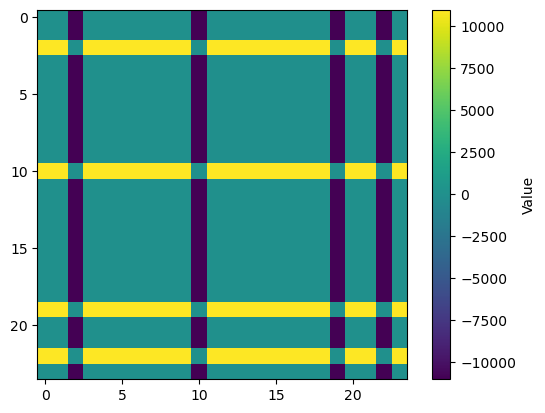

126.0
-1.0 1.0


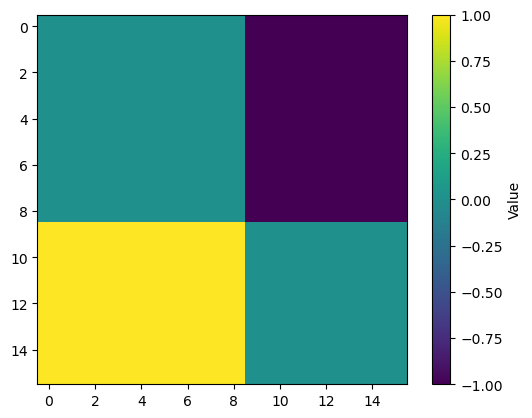

616100.0
-22001.0 22001.0


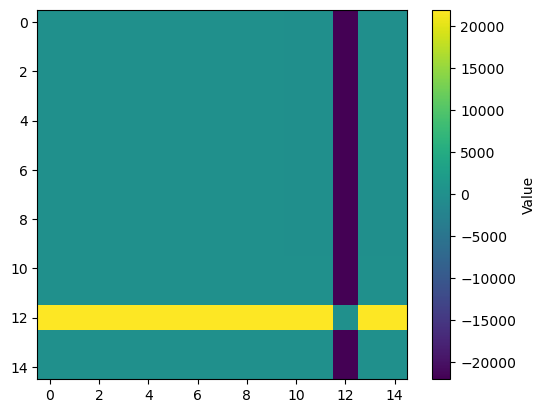

In [11]:
for i in range(10):
    show_problems(minHash_test.signature_mtxs[i])

I think the weirdness has to do with the differences of 1 vs 1,000 vs 20,000. This indicates that almost all of the buckets are the exact same for almost all of the reads. Then randomly it looks like a read is somehow so different than the rest that it has almost no buckets similar. This merits further investigating.

#### minHash with large band size

In [26]:
minHash_df_ranges = []
for i in range(10):
    start_region = i * 100
    end_region =  (i+1) * 100
    minHash_df_ranges.append(dataToPandas("minHash", read_in = False, band_sizes = range(100,501,100), matrix_range = range(start_region, end_region)))

minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   20.9s finished


Compute Time:	 20.880352020263672
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.9s finished


Compute Time:	 14.921144008636475
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.065966844558716
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.0s finished


Compute Time:	 15.013811588287354
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.6s finished


Compute Time:	 15.637235641479492
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.129993677139282
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.9s finished


Compute Time:	 14.91419792175293
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.087099552154541
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.2s finished


Compute Time:	 15.218103647232056
minHash
Load Time:	 1.18


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s


Compute Time:	 14.29979920387268


[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.3s finished


In [27]:
minHash_df_ranges

[   found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6305     7188       5558     7224         100  0.877156  0.76938
 1       6305     7188       5558     7224         200  0.877156  0.76938
 2       6305     7188       5558     7224         300  0.877156  0.76938
 3       6305     7188       5558     7224         400  0.877156  0.76938
 4       6305     7188       5558     7224         500  0.877156  0.76938,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7388     8050       7021     7986         100  0.917764  0.879164
 1       7388     8050       7021     7986         200  0.917764  0.879164
 2       7388     8050       7021     7986         300  0.917764  0.879164
 3       7388     8050       7021     7986         400  0.917764  0.879164
 4       7388     8050       7021     7986         500  0.917764  0.879164,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6950     7857       

In [28]:
tiny_minHash_df_ranges = []
for i in range(10):
    start_region = i * 100
    end_region =  (i+1) * 100
    tiny_minHash_df_ranges.append(dataToPandas("minHash", read_in = False, band_sizes = range(1,2), matrix_range = range(start_region, end_region)))

minHash
Load Time:	 1.21


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.4395036697387695
minHash
Load Time:	 1.53


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.464499473571777
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.378319263458252
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.446295499801636
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.169932842254639
minHash
Load Time:	 1.5


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.448399305343628
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.120500087738037
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 6.9693169593811035
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.234246730804443
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.7334558963775635


In [29]:
tiny_minHash_df_ranges

[   found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6305     7188       5558     7224           1  0.877156  0.76938,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7388     8050       7021     7986           1  0.917764  0.879164,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6950     7857       6259     7799           1  0.884562  0.802539,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7026     7681       6765     7759           1  0.914725  0.871891,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6977     7984       6306     7947           1  0.873873  0.793507,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6632     7525       6341     7557           1  0.881329  0.83909,
    found_pos  max_pos  found_err  max_err  band_sizes      tpr       fpr
 0       6060     6970  

In [30]:
minHash_df

,found_pos,max_pos,found_err,max_err,band_sizes,tpr,fpr
0,1009629,1133473,918640,1130015,1,0.890739,0.812945
1,1009629,1133473,918640,1130015,2,0.890739,0.812945
2,1009629,1133473,918640,1130015,3,0.890739,0.812945
3,1009629,1133473,918640,1130015,4,0.890739,0.812945
4,1009629,1133473,918640,1130015,5,0.890739,0.812945
...,...,...,...,...,...,...,...
194,1009629,1133473,918640,1130015,195,0.890739,0.812945
195,1009629,1133473,918640,1130015,196,0.890739,0.812945
196,1009629,1133473,918640,1130015,197,0.890739,0.812945
197,1009629,1133473,918640,1130015,198,0.890739,0.812945


Repetitive Regions:
```
chr16	5484407	5484741
chr6	30332563	30332851
```

Non Repetitive:
```
chr16	14396657	14397075
chr6	23559543	23559857
```

`
samtools view -bh gs://fc-28761d6c-5677-4941-86e7-6e42b59a27f4/willard/HG002/HG002_haplotagged.bam\
      chr16:5484407-5484741 > repetitive.bam`

In [12]:
repetitive_paths = ["chr16_5484207-5484941.npy", "chr6_30332363-30333051.npy"]
non_repetitive_paths = ["chr16_14396457-14397275.npy", "chr6_23559343-23560057.npy"]

def getAdjacencyMatrix(path, matrix_path, bands = range(1,200, 40)):
    euclidean_path = "../../../output/signatureMtxs/euclidean/1000,20,5,1"
    sketch_path = "../../../output/signatureMtxs/sketch/1000,20,40"

    if path == "euclidean":
        path = euclidean_path
    elif path == "sketch":
        path = sketch_path

    filter_test = signatureMtxs()
    filter_test.loadMatrix(os.path.join(path, matrix_path))
    
    matrix = filter_test.signature_mtxs[-1]
    labels = matrix[0,:].astype('int8')
    signature_matrix = matrix[1:,:]

    outputs = []
    adjacency_matrices = []
    for i in bands:
        output, adjacency_matrix = filter_test.tprSignatureMatrix(signature_matrix, i, labels, wantAdjacencyMatrix=True)
        outputs.append(output)
        adjacency_matrices.append(adjacency_matrix)
    return outputs, adjacency_matrices

"""
def plotAdjacencyMatrices(adj_matrices, ):
    def plotAdjacencyMatrix(adjacencyMatrix):
        n = adjacencyMatrix.shape[0]
        plt.imshow(adjacencyMatrix, 
                   cmap = 'binary_r', 
                   interpolation='nearest', 
                   vmin=0, vmax=1
        )
        plt.title(f"Adjacency Matrix, ")
        plt.xticks(np.arange(n), np.arange(1, n + 1))
        plt.yticks(np.arange(n), np.arange(1, n + 1))

        plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
        plt.xlabel(f"White in pos i,j indicates i connects j")
        for x in self.firstOcc[1:]:
            plt.axhline(x - 0.5, color='red', linestyle='-', linewidth=2)
            plt.axvline(x - 0.5, color='red', linestyle='-', linewidth=2)
    
    for matrix in adj_matrices:
        plotAdjacencyMatrix(matrix, )
"""


'\ndef plotAdjacencyMatrices(adj_matrices, ):\n    def plotAdjacencyMatrix(adjacencyMatrix):\n        n = adjacencyMatrix.shape[0]\n        plt.imshow(adjacencyMatrix, \n                   cmap = \'binary_r\', \n                   interpolation=\'nearest\', \n                   vmin=0, vmax=1\n        )\n        plt.title(f"Adjacency Matrix, ")\n        plt.xticks(np.arange(n), np.arange(1, n + 1))\n        plt.yticks(np.arange(n), np.arange(1, n + 1))\n\n        plt.tick_params(axis=\'x\', top=True, bottom=False, labeltop=True, labelbottom=False)\n        plt.xlabel(f"White in pos i,j indicates i connects j")\n        for x in self.firstOcc[1:]:\n            plt.axhline(x - 0.5, color=\'red\', linestyle=\'-\', linewidth=2)\n            plt.axvline(x - 0.5, color=\'red\', linestyle=\'-\', linewidth=2)\n    \n    for matrix in adj_matrices:\n        plotAdjacencyMatrix(matrix, )\n'

### Euclidean

In [13]:
bands = list(range(1,200, 1))

#### Repetitive Regions

In [14]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

TypeError: plotROC() got an unexpected keyword argument 'bands'

In [15]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

TypeError: plotROC() got an unexpected keyword argument 'bands'

#### Non-Repetitive Regions

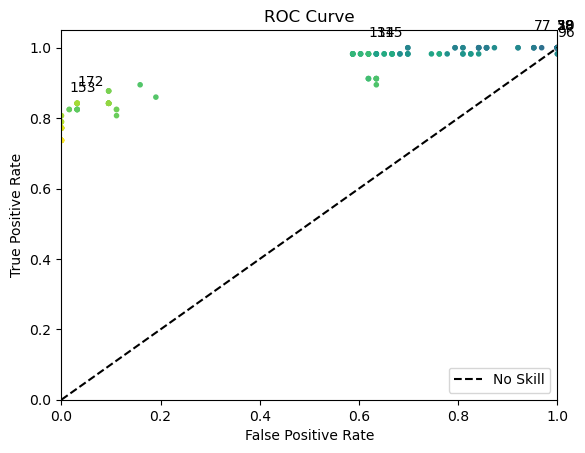

In [19]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

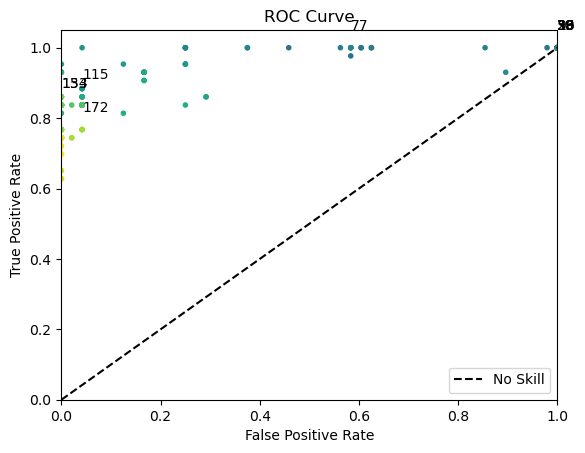

In [20]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

### Sketch

#### Repetitive Regions

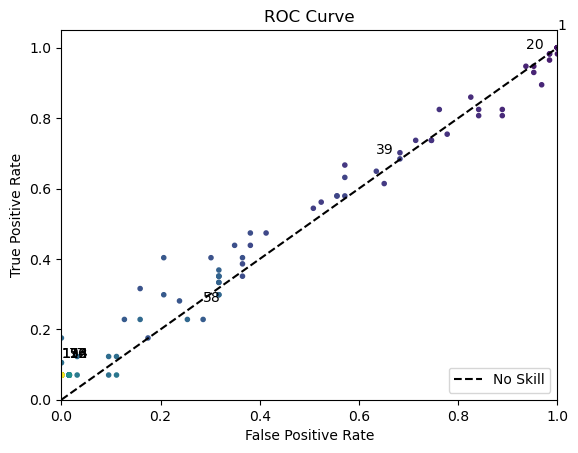

In [21]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

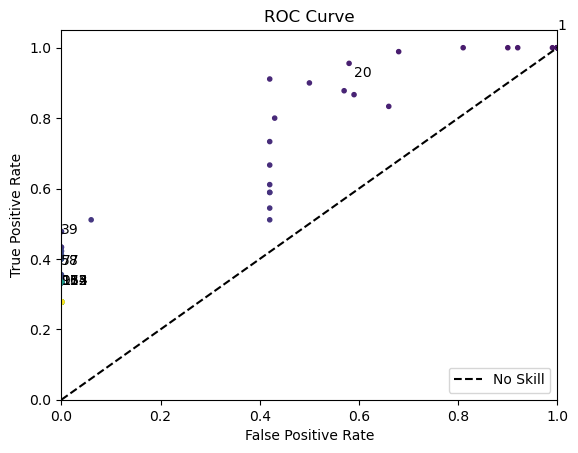

In [22]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

#### Non-Repetitive Regions

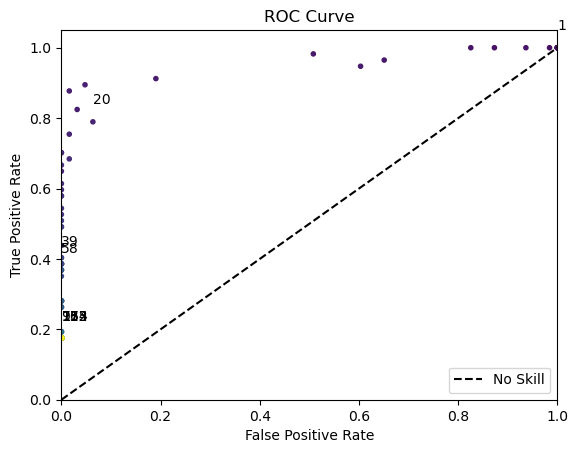

In [23]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

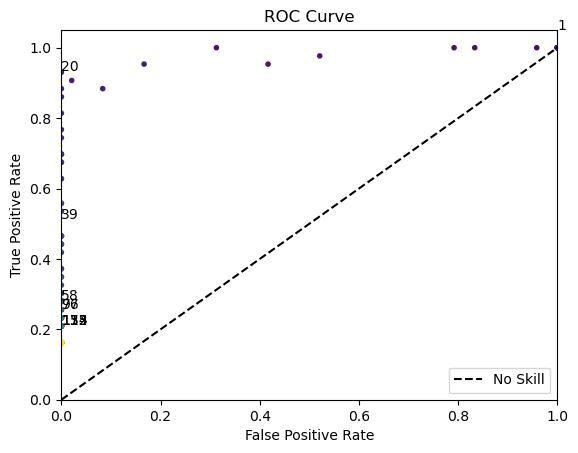

In [24]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

# Load Dif Band Sizes

## Functions

In [7]:
"""
Returns sorted seqs and labels by labels from fastq file
"""
def readFastq(fastqFile:str):
    seqs :list[str] = []
    labels :list[str] = []
    with open(fastqFile,"r") as f:
        i = 0
        curHap = -1
        for line in f.readlines():
            if i % 4 == 0:
                for segment in line.strip().split(" "):
                    if segment.startswith("HP"):
                        curHap = segment.split(":")[-1]
            elif i % 4 == 1:
                if curHap == -1:
                    continue
                curSeq = line.strip()
                seqs.append(curSeq)
                labels.append(curHap)
                curHap = -1
                curSeq = ""
            i += 1
    seqs, labels = zip(*sorted(zip(seqs, labels), key = lambda x : x[1]))
    return seqs, labels

"""
Iterate over all band sizes for a single region. Called in parallel over every region at once.
"""
def test_bands(signature_matrix_directory, file, band_sizes, include_length = False, include_hash = False, save_adjacency = False):

    signature_matrix = np.load(os.path.join(signature_matrix_directory, file))
    labels = signature_matrix[0,:].astype('int8')
    signature_matrix = signature_matrix[1:,:]

    if include_length or type(include_hash) is int:
        fastq_file = os.path.join("../../../output/HG002_20bp/all_chr/", file[:-3]) + "fastq"
        seqs, _ = readFastq(fastq_file)
        lengths = [len(x) for x in seqs]
        if 0 in lengths:
            return 0
    else:
        seqs = None
        lengths = None

    adjacency_output_file = ""
    if save_adjacency:
        adjacency_dir = "../../../output/adjacency_matrices"
        params_dir = os.path.basename(signature_matrix_directory+f"_band_size={list(band_sizes)[0]}") 
        adjacency_output_dir = os.path.join(adjacency_dir, params_dir)
        os.makedirs(adjacency_output_dir, exist_ok = True)
        adjacency_output_file = os.path.join(adjacency_output_dir,file)

    counts = np.zeros((4, len(band_sizes)), dtype = int)
    for i, band_size in enumerate(band_sizes):
        counts[:,i] = tprSignatureMatrix(
            signature_matrix, 
            band_size, 
            labels, 
            include_length = include_length, 
            include_hash = include_hash, 
            seqs = seqs,
            lengths = lengths,
            save_adjacency = save_adjacency, adjacency_output_file = adjacency_output_file
        )
    return counts

"""
Generate TPR and FPR for a given signature matrix, band length, and label list
Returns [test_pos, tot_pos, test_neg, tot_neg]
"""
def tprSignatureMatrix(signature_matrix, band_length, labels, 
                       include_length = False, include_hash = False, 
                       seqs = None, lengths = 0, save_adjacency = False, adjacency_output_file = ""):

    def comparator_length(include_length, a_len, b_len):
        # Absolute Threshold
        if include_length[1] == 0:
            return abs(a_len-b_len) <= include_length[0]
        # Percentage Threshold
        else:
            return abs(a_len-b_len) / max(a_len,b_len) <= include_length[0]

    def comparator_hash(include_hash, a, b, a_len, b_len):
        min_len = min(a_len, b_len)
        num_compare = max(int(min_len * (include_hash / 100)), 1)
        indices = np.random.choice(min_len, num_compare, replace=False)
        a_subseq = np.array(list(a))[indices]
        b_subseq = np.array(list(b))[indices]
        return hash(a_subseq.tobytes()) == hash(b_subseq.tobytes())

    def connectBucket(bucket, adjacencyMatrix):
        for i in range(len(bucket)-1):
            for j in range(i+1, len(bucket)):
                if include_length and not comparator_length(include_length, lengths[i], lengths[j]):
                    continue
                if type(include_hash) is int and not comparator_hash(include_hash, seqs[i], seqs[j], lengths[i], lengths[j]):
                    continue
                adjacencyMatrix[bucket[i],bucket[j]] = True
                adjacencyMatrix[bucket[j],bucket[i]] = True
        return adjacencyMatrix

    firstOcc = np.argmax(labels>1)
    adjacencyMatrix = np.zeros((len(labels), len(labels)))

    for i in range(signature_matrix.shape[0]//band_length):
        buckets = defaultdict(list[int])
        startBucket = i*band_length
        endBucket = (i+1)*band_length
        for j in range(signature_matrix.shape[1]):
            buckets[signature_matrix[startBucket:endBucket, j].tobytes()].append(j)
        for bucket in buckets.values():
            adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)

    if save_adjacency:
        np.save(adjacency_output_file, adjacencyMatrix)

    return tpr_fpr(len(labels), firstOcc, adjacencyMatrix)

"""
Generate true positive rate and false positive rate for a given adjacency matrix
"""
def tpr_fpr(n, firstOcc, adjacencyMatrix):
    trueMask = np.zeros((n , n), dtype = bool)
    trueMask[:firstOcc, :firstOcc] = 1
    trueMask[firstOcc:, firstOcc:] = 1

    true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
    tot_pos = int((np.sum(trueMask) - n)/2)
    false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
    tot_neg = int(np.sum(~trueMask)/2)

    local_counts = np.array([true_pos, tot_pos, false_pos, tot_neg])

    return local_counts

"""
Callable function to parallelize banding step
"""
def parallel_regions(signature_matrix_directory, band_sizes = range(1, 500), verbose = 0,
                     non_repetitive = False, repetitive = False, 
                     include_hash = False, include_length = False,
                     save_adjacency = False):
    # Get correct numpy file set
    if repetitive or non_repetitive:
        def bed_to_npy(bed):
            chrom, start, end = bed.split("\t")
            return f"{chrom}_{int(start)-20}-{int(end)+20}.npy"
        repetitive_regions_file = "../../../output/analysis/human_chm13v2.0_maskedY_rCRS.trf.bed"
        with open(repetitive_regions_file, "r") as f:
            repetitive_regions = set([bed_to_npy(x) for x in f.read().splitlines()])
    if non_repetitive:
        numpy_files = [x for x in os.listdir(signature_matrix_directory) if x not in repetitive_regions]
    if repetitive:
        numpy_files = [x for x in os.listdir(signature_matrix_directory) if x in repetitive_regions]
    if repetitive and non_repetitive or not repetitive and not non_repetitive:
        numpy_files = os.listdir(signature_matrix_directory)

    inputs = zip(repeat(signature_matrix_directory), 
                 numpy_files, 
                 repeat(band_sizes), 
                 repeat(include_length), 
                 repeat(include_hash),
                 repeat(save_adjacency)
    )
    num_cores = multiprocessing.cpu_count()

    print("Running Parallel Step")
    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=verbose)(delayed(test_bands)(i, j, k, l, m, n) for i, j, k, l, m, n  in inputs)
    print("Total time\t:", time.time() - start)

    counts = outputs[0]
    for output in outputs[1:]:
        counts += output
    return counts


In [3]:
"""
Convert from numpy array to pandas df for plotting
"""
def numpy_counts_to_pandas(array):
    df = pd.DataFrame()
    df["true_pos"] = array[0,:]
    df["tot_pos"] = array[1,:]
    df["false_pos"] = array[2,:]
    df["tot_neg"] = array[3,:]

    df["tpr"] = df["true_pos"] / df["tot_pos"]
    df["fpr"] = df["false_pos"] / df["tot_neg"]
    df["band_size"] = range(1,500)

    return df

"""
Load or Build matrix and save based on input parameters
"""
def get_counts_df(signature_matrix_directory, non_repetitive = False, repetitive = False, 
                  include_hash = False, include_length = False, verbose = 0,
                  build = False, band_sizes = range(1,500), save_adjacency = False, save_df = True, load = True):
    out_path = "../../../output/analysis"

    if "euclidean" in signature_matrix_directory:
        out_path = os.path.join(out_path, "euclidean")
    elif "sketch" in signature_matrix_directory:
        out_path = os.path.join(out_path, "sketch")
    elif "minhash" in signature_matrix_directory.lower():
        out_path = os.path.join(out_path, "minHash")

    out_file_name = ""
    in_dir_name = os.path.basename(signature_matrix_directory)

    params = in_dir_name.split(",")
    num_hashes = params[0]
    out_file_name += f"num_hashes={num_hashes}_"
    k_size = params[1]
    out_file_name += f"k={k_size}"

    if "euclidean" in signature_matrix_directory:
        bin_size = params[2]
        out_file_name += f"_bin_size={bin_size}"

    if repetitive and not non_repetitive:
        out_file_name += "_repetitive_regions"
    elif non_repetitive and not repetitive:
        out_file_name += "_non_repetitive_regions"
    else:
        out_file_name += "_all_regions"

    if type(include_hash) is int:
        out_file_name += f"_hash_perc={include_hash}"
    if include_length:
        out_file_name += "_length"
        if include_length[1] == 0:
            out_file_name += f"_abs={include_length[0]}"
        else:
            out_file_name += f"_perc={include_length[0]}"
    out_path = os.path.join(out_path, out_file_name)

    if os.path.isfile(out_path) and load:
        print("Loading from disk")
        print(out_path)
        return pd.read_csv(out_path, sep="\t", encoding="utf-8")
    
    print(f"Save Path\t{out_path}")

    if build:
        print("Building Matrix")

        counts = parallel_regions(signature_matrix_directory, band_sizes, verbose,
                        non_repetitive, repetitive, 
                        include_hash, include_length, save_adjacency = save_adjacency)
        df = numpy_counts_to_pandas(counts)
    else:
        print("Not building")

    if save_df and build:
        df.to_csv(out_path, sep='\t', encoding='utf-8', index=False, header=True)

    return df



"""
Plot the ROC curve
"""
def plotROC(df, title = "ROC Curve"):
    bands = df["band_size"]
    tprs = df["tpr"]
    fprs = df["fpr"]
    

    #area_under_curve = auc(fprs, tprs)

    # Plot the ROC curve
    fig, ax = plt.subplots()

    plt.scatter(fprs, tprs, c = bands, marker = ".")
    num_labels = min(10, len(bands))
    scale = int(len(bands)//num_labels)
    for i in range(num_labels):
        index = i*scale
        ax.text(fprs[index], tprs[index]+0.05, bands[index])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "lower right")

    plt.show()

"""
Plot the ROC curve for multiple different paramters
"""
def plotROCwithParams(dfs, params, title = "ROC Curve with params", param_header = "", 
                      false_negative = False):
    if len(dfs) is not len(params):
        print("Number of inputs and parameters is not the same!")
        return

    fig, ax = plt.subplots()

    plt.ylim([0.0, 1.0])
    plt.title(title)

    # Add y=x line
    if false_negative:
        #plt.xlim([0.0, len(dfs[0]["band_size"])+1])
        plt.ylabel("False Negative Rate")
        #plt.xlabel("Band Size")
        plt.xlabel('False Positive Rate')
        plt.xlim([0.0, 1.0])

    else:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    cmap = matplotlib.cm.get_cmap('plasma')
    norm = plt.Normalize(vmin=0, vmax=len(params))

    for i, df in enumerate(dfs):
        bands = df["band_size"]
        tprs = df["tpr"]
        fprs = df["fpr"]

        # Plot the ROC curve
        if false_negative:
            false_negatives_series = (df["tot_pos"]-df["true_pos"])/df["tot_pos"]
            plt.scatter(fprs, false_negatives_series, c = cmap(norm(i)), marker = ".", label = param_header + f"{params[i]}")
        else:
            plt.scatter(fprs, tprs, 
                        c = cmap(norm(i)), 
                        marker = ".",
                        label= param_header + f"{params[i]}"
            )

        # Add AUC label TODO
        #area_under_curve = auc(fprs, tprs)

        # Add band size labels
        #num_labels = min(10, len(bands))
        #scale = int(len(bands)//num_labels)
        #for i in range(num_labels):
        #    index = i*scale
        #    ax.text(fprs[index], tprs[index]+0.05, bands[index])

    plt.legend(loc = "upper left", bbox_to_anchor = (1,0,.5,1))
    plt.show()

## Cosine Distance

In [28]:
sketch_signature_matrix_directory = "../../../output/signatureMtxs_20bp/sketch/1000,21,1"
sketch_df = get_counts_df(sketch_signature_matrix_directory)

Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


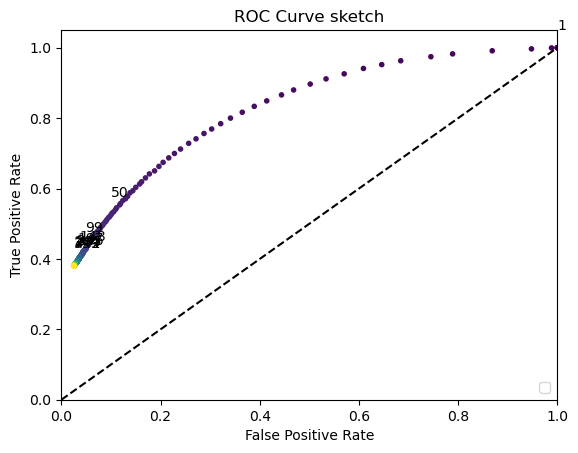

In [32]:
plotROC(sketch_df, "ROC Curve sketch")

## Cosine with Length Filtering

Absolute Distance Filtering

In [33]:
sketch_abs_length_dfs = []
for i in range(0, 100, 20):
    local_df = get_counts_df(sketch_signature_matrix_directory, include_length = (i, 0))
    sketch_abs_length_dfs.append(local_df)

Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_abs=0
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_abs=20
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_abs=40
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_abs=60
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_abs=80


Plot many curves on same plot

/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


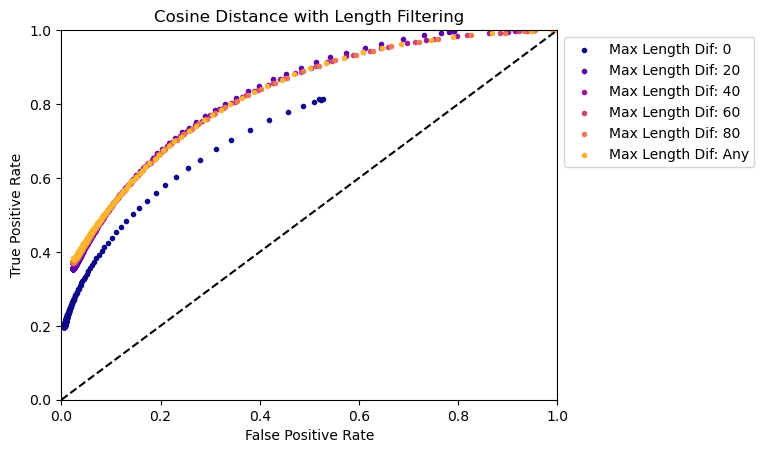

In [34]:
dfs = sketch_abs_length_dfs
params = list(range(0, 100, 20))
dfs.append(sketch_df)
params.append("Any")

plotROCwithParams(dfs, 
                  params, 
                  title = "Cosine Distance with Length Filtering", 
                  param_header = "Max Length Dif: "
)

Relative Distance Filtering

In [35]:
sketch_perc_length_dfs = []
for i in range(4, 21, 4):
    local_df = get_counts_df(sketch_signature_matrix_directory, include_length = (i, 1))
    sketch_perc_length_dfs.append(local_df)

Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_perc=4
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_perc=8
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_perc=12
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_perc=16
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_length_perc=20


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


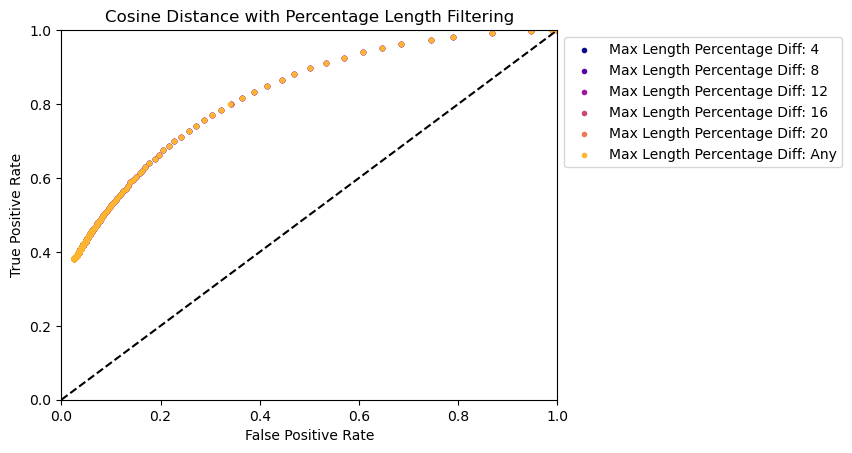

In [36]:
dfs = sketch_perc_length_dfs
params = list(range(4, 21, 4))
dfs.append(sketch_df)
params.append("Any")

plotROCwithParams(dfs, 
                  params, 
                  title = "Cosine Distance with Percentage Length Filtering", 
                  param_header = "Max Length Percentage Diff: "
)

## Cosine with Hash Filtering

Took two hours and didn't complete. This soundly sits in the next steps section of my work.

In [39]:
sketch_hash_10_df = get_counts_df(sketch_signature_matrix_directory, include_hash = 10)

Save Path	../../../output/analysis/sketch/num_hashes=1000_k=21_all_regions_hash_perc=10
Not building


In [ ]:
plotROCwithParams((sketch_hash_10_df, sketch_df), 
                  ("10 Percent Hashed", ""), 
                  title = "Cosine Distance with Hash Filtering", 
                  param_header = ""
)

## Cosine in Non-Repetitive and Repetitive Regions

In [40]:
sketch_non_repetitive_df = get_counts_df(sketch_signature_matrix_directory, non_repetitive = True)
sketch_repetitive_df = get_counts_df(sketch_signature_matrix_directory, repetitive = True)

Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_non_repetitive_regions
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=21_repetitive_regions


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


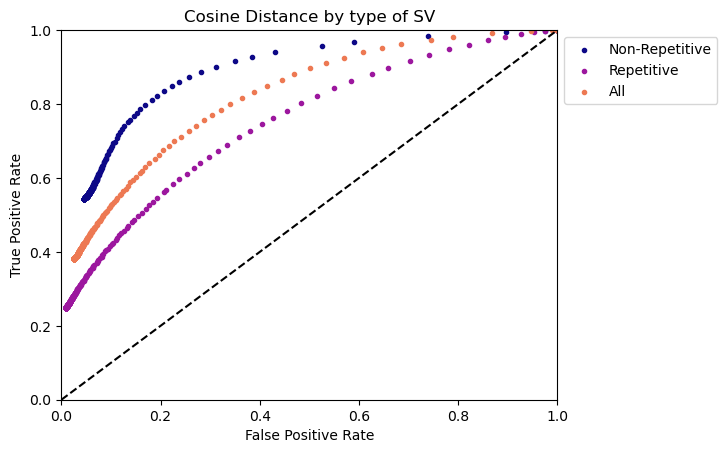

In [41]:
plotROCwithParams((sketch_non_repetitive_df, sketch_repetitive_df, sketch_df), 
                  ("Non-Repetitive", "Repetitive", "All"), 
                  title = "Cosine Distance by type of SV", 
                  param_header = ""
)

## Cosine with different size k

In [42]:
sketch_k11_df = get_counts_df("../../../output/signatureMtxs_20bp/sketch/1000,11,1", )

sketch_k31_df = get_counts_df("../../../output/signatureMtxs_20bp/sketch/1000,31,1", )


Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=11_all_regions
Loading from disk
../../../output/analysis/sketch/num_hashes=1000_k=31_all_regions


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


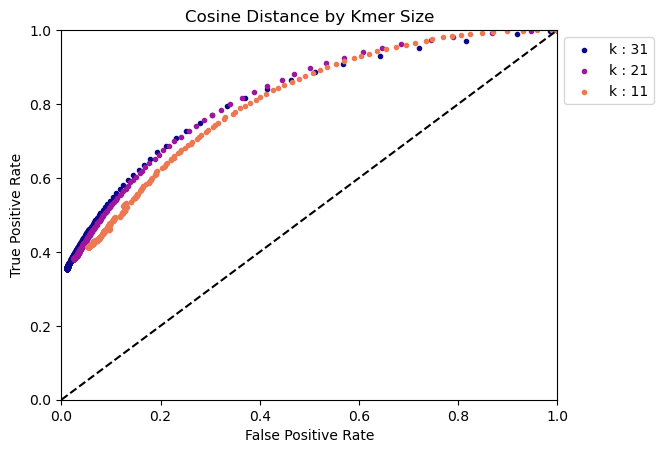

In [43]:
plotROCwithParams((sketch_k31_df, sketch_df, sketch_k11_df), 
                  ["31", "21", "11"], 
                  title = "Cosine Distance by Kmer Size", 
                  param_header = "k : "
)

## Euclidean Distance

In [15]:
euclidean_signature_matrix_directory = "../../../output/signatureMtxs_20bp/euclidean/1000,21,16,1"
euclidean_df = get_counts_df(euclidean_signature_matrix_directory)

Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=16_all_regions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


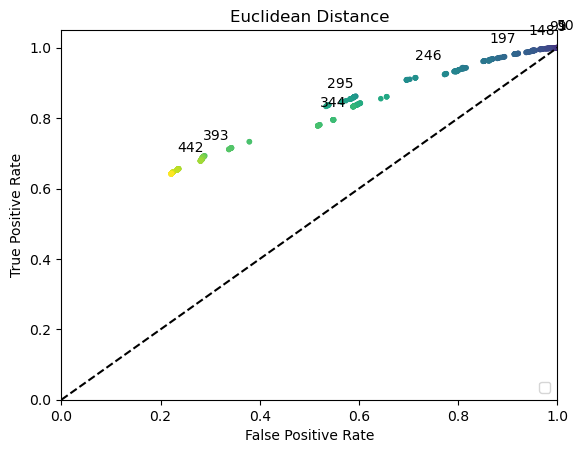

In [45]:
plotROC(euclidean_df, "Euclidean Distance")

## Euclidean Distance  Repetitive vs Non-Repetitive

In [46]:
euclidean_non_repetitive_df = get_counts_df(euclidean_signature_matrix_directory, non_repetitive = True)
euclidean_repetitive_df = get_counts_df(euclidean_signature_matrix_directory, repetitive = True)

Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=16_non_repetitive_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=16_repetitive_regions


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


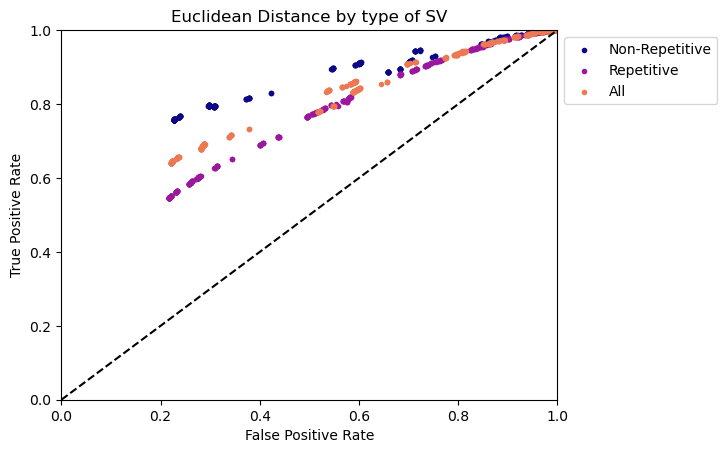

In [47]:
plotROCwithParams((euclidean_non_repetitive_df, euclidean_repetitive_df, euclidean_df), 
                  ("Non-Repetitive", "Repetitive", "All"), 
                  title = "Euclidean Distance by type of SV", 
                  param_header = ""
)

## Euclidean Distance by Bin Size

In [49]:
euclidean_dir = "../../../output/signatureMtxs_20bp/euclidean"

euclidean_dfs_by_bin_size = []

for bin_size_path in [x for x in os.listdir(euclidean_dir) if "1000,21" in x]:
    local_df = get_counts_df(os.path.join(euclidean_dir, bin_size_path))
    euclidean_dfs_by_bin_size.append(local_df)

Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=16_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=13_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=6_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=5_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=4_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=8_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=17_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=1_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=12_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=21_bin_size=19_all_regions
Loading from disk
../../.

/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


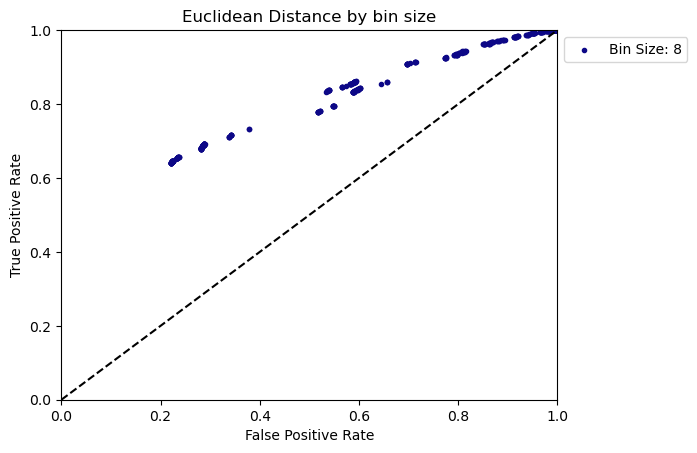

In [50]:
plotROCwithParams(euclidean_dfs_by_bin_size[7:8], 
                  range(1,20)[7:8], 
                  title = "Euclidean Distance by bin size", 
                  param_header = "Bin Size: "
)

## Euclidean with numHashes = 5000

In [51]:
euclidean_big_hash_df = get_counts_df("../../../output/signatureMtxs_20bp/euclidean/5000,21,1,1", )

Loading from disk
../../../output/analysis/euclidean/num_hashes=5000_k=21_bin_size=1_all_regions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


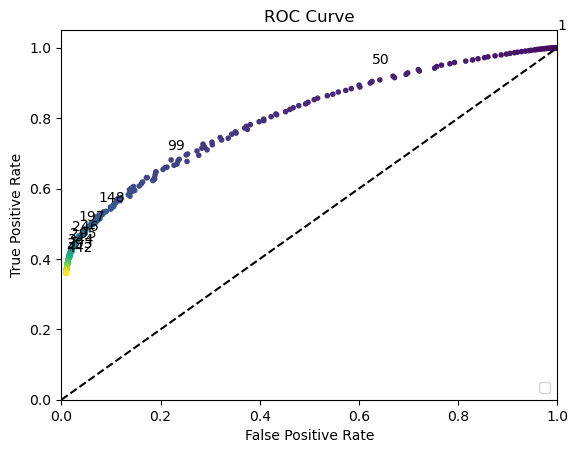

In [52]:
plotROC(euclidean_big_hash_df)

/tmp/ipykernel_1283197/919510021.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/919510021.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


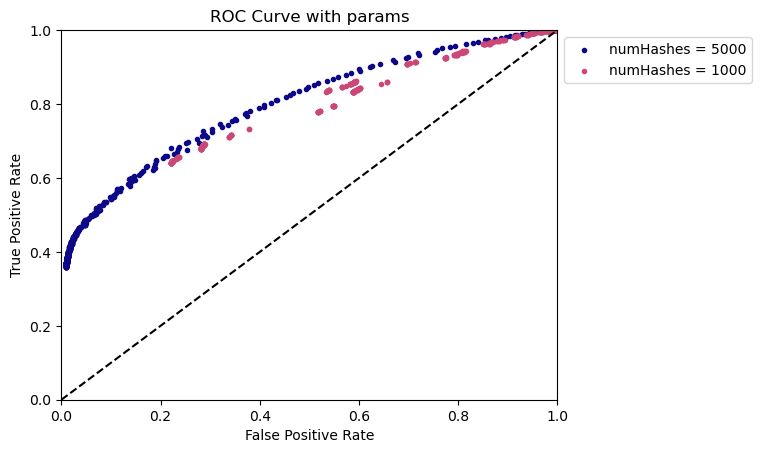

In [111]:
plotROCwithParams(
    (euclidean_big_hash_df, euclidean_df),
    ("numHashes = 5000", "numHashes = 1000"),
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


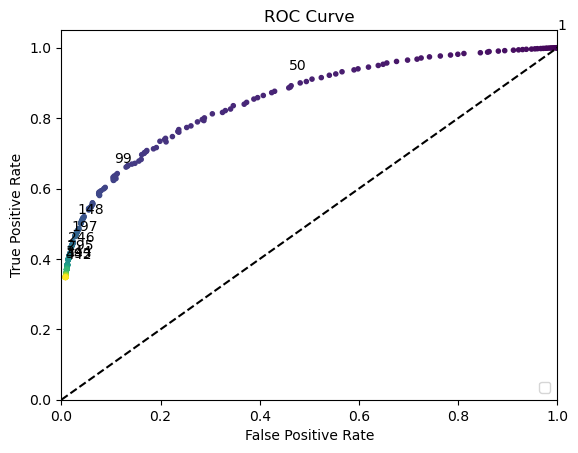

In [113]:
plotROC(euclidean_k11_df)

## Euclidean with k = 11 and k = 31

In [13]:
euclidean_k11_df = get_counts_df("../../../output/signatureMtxs_20bp/euclidean/1000,11,1,1", )
euclidean_k31_df = get_counts_df("../../../output/signatureMtxs_20bp/euclidean/1000,31,1,1", )


Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=11_bin_size=1_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=31_bin_size=1_all_regions


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


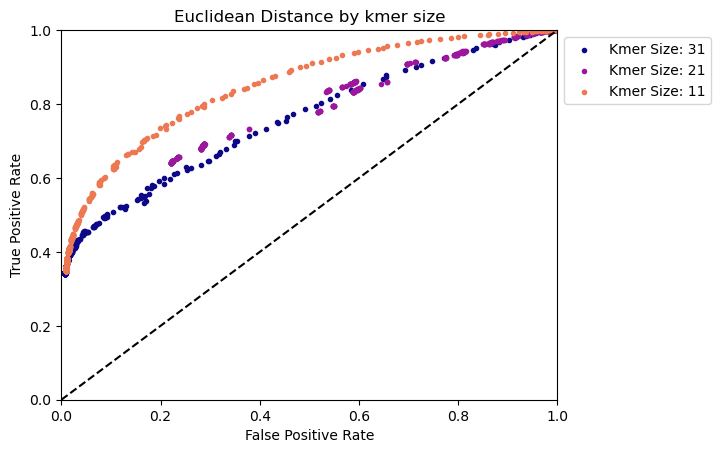

In [54]:
plotROCwithParams((euclidean_k31_df, euclidean_df, euclidean_k11_df),
                ("31","21","11"),
                title = "Euclidean Distance by kmer size", 
                param_header = "Kmer Size: "
)


## Test k=11 for different types of SVs

In [56]:
euclidean_11mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,11,1,1"

euclidean_non_repetitive_df11 = get_counts_df(euclidean_11mer_dir, non_repetitive = True)
euclidean_repetitive_df11 = get_counts_df(euclidean_11mer_dir, repetitive = True)


Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=11_bin_size=1_non_repetitive_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=11_bin_size=1_repetitive_regions


/tmp/ipykernel_1283197/4215545627.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/4215545627.py:153: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


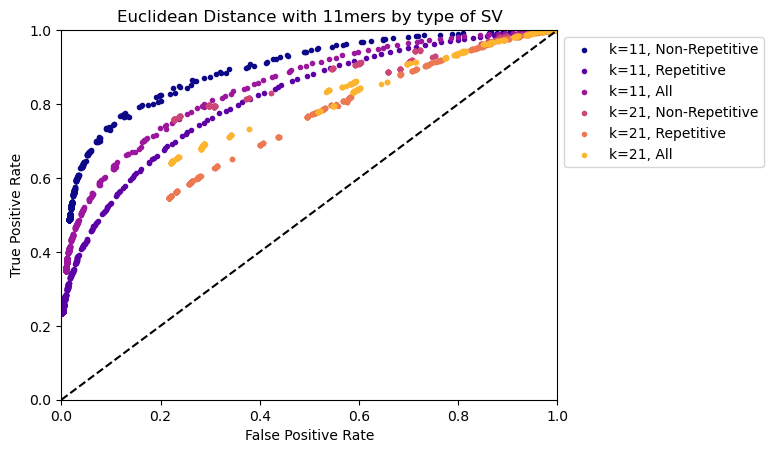

In [96]:
plotROCwithParams((euclidean_non_repetitive_df11, euclidean_repetitive_df11, euclidean_k11_df, 
                    euclidean_non_repetitive_df, euclidean_repetitive_df, euclidean_df), 
                  ("k=11, Non-Repetitive", "k=11, Repetitive", "k=11, All",
                  "k=21, Non-Repetitive", "k=21, Repetitive", "k=21, All"), 
                  title = "Euclidean Distance with 11mers by type of SV", 
                  param_header = ""
)

/tmp/ipykernel_1283197/1902254904.py:143: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/1902254904.py:154: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, false_negatives_series, c = cmap(norm(i)), marker = ".", label = param_header + f"{params[i]}")
/tmp/ipykernel_1283197/1902254904.py:154: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with

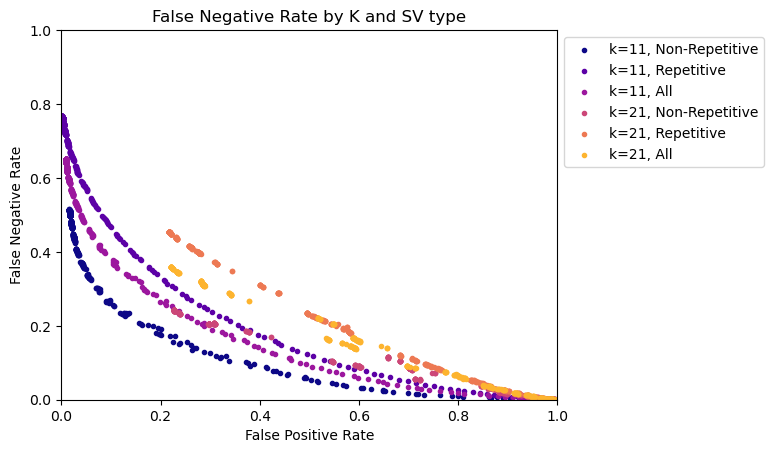

In [101]:
plotROCwithParams((euclidean_non_repetitive_df11, euclidean_repetitive_df11, euclidean_k11_df, 
                    euclidean_non_repetitive_df, euclidean_repetitive_df, euclidean_df), 
                  ("k=11, Non-Repetitive", "k=11, Repetitive", "k=11, All",
                  "k=21, Non-Repetitive", "k=21, Repetitive", "k=21, All"), 
                  title = "False Negative Rate by K and SV type", 
                  param_header = "", false_negative = True
)

In [23]:
# Save the adjacency matrices from k=11 for band_size = 80
euclidean_11mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,7,1,1"
for i in range(5, 130, 5):
    try:    
        euclidean_non_repetitive_df11 = get_counts_df(
            euclidean_11mer_dir, 
            band_sizes = [i],
            save_adjacency = True, 
            save_df = False, 
            load = False, 
            build = True
        )
    except:
        print(i)

# Something breaks due to using only a single band size but it does correctly save the adjacency matrices so I'm ignoring it.


Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 31.460876941680908
5
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 28.94804811477661
10
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 28.296475410461426
15
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 28.24459171295166
20
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 28.35703992843628
25
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Building Matrix
Running Parallel Step
Total time	: 28.134414434432983
30
Save Path	../../../output/analysis/euc

## Euclidean with k = 7 and 15

In [18]:
euclidean_5mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,5,1,1"
euclidean_df5 = get_counts_df(euclidean_7mer_dir, build = True, save_df = True)

euclidean_7mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,7,1,1"
euclidean_df7 = get_counts_df(euclidean_7mer_dir, build = False, save_df = True)

euclidean_15mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,15,1,1"
euclidean_df15 = get_counts_df(euclidean_15mer_dir, build = False, save_df = True)

Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_all_regions
Loading from disk
../../../output/analysis/euclidean/num_hashes=1000_k=15_bin_size=1_all_regions


/tmp/ipykernel_3892326/2253370976.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_3892326/2253370976.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


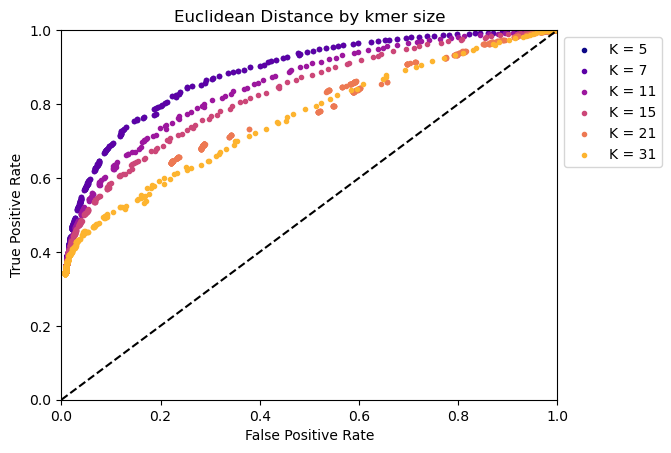

In [19]:
plotROCwithParams(
    (euclidean_df5, euclidean_df7, euclidean_k11_df, euclidean_df15, euclidean_df, euclidean_k31_df),
    ("5", "7", "11", "15", "21", "31"),
    title = "Euclidean Distance by kmer size",
    param_header = "K = "
)

In [31]:
euclidean_7mer_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,7,1,1"
euclidean_non_repetitive_df7 = get_counts_df(euclidean_7mer_dir, build = True, non_repetitive = True)
euclidean_repetitive_df7 = get_counts_df(euclidean_7mer_dir, build = True, repetitive = True)

Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_non_repetitive_regions
Building Matrix
Running Parallel Step
Total time	: 76.73586511611938
Save Path	../../../output/analysis/euclidean/num_hashes=1000_k=7_bin_size=1_repetitive_regions
Building Matrix
Running Parallel Step
Total time	: 86.77694797515869


/tmp/ipykernel_3892326/2253370976.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_3892326/2253370976.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


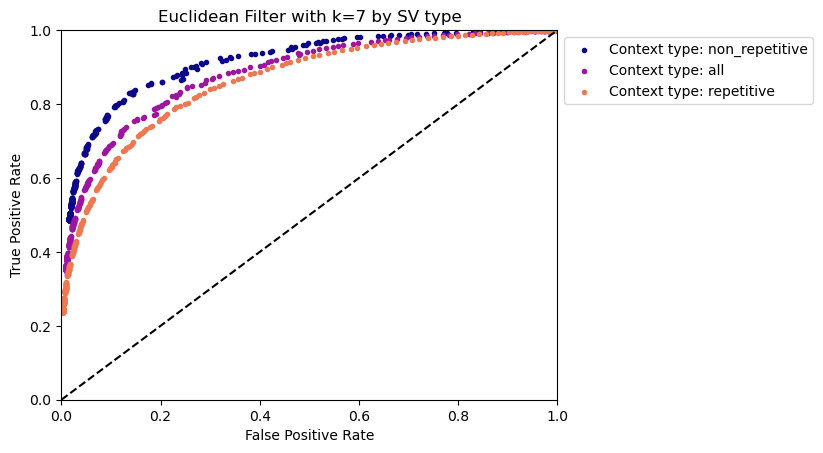

In [35]:
plotROCwithParams(
    [euclidean_non_repetitive_df7, euclidean_df7, euclidean_repetitive_df7],
    ["non_repetitive", "all", "repetitive"],
    title = "Euclidean Filter with k=7 by SV type",
    param_header = "Context type: "
)

## Jaccard Distance

In [26]:
minHash_signature_matrix_directory = "../../../output/signatureMtxs_20bp/minHash/1000,21,1"
minHash_df = get_counts_df(minHash_signature_matrix_directory, build = True)

Loading from disk
../../../output/analysis/minHash/num_hashes=1000_k=21_all_regions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


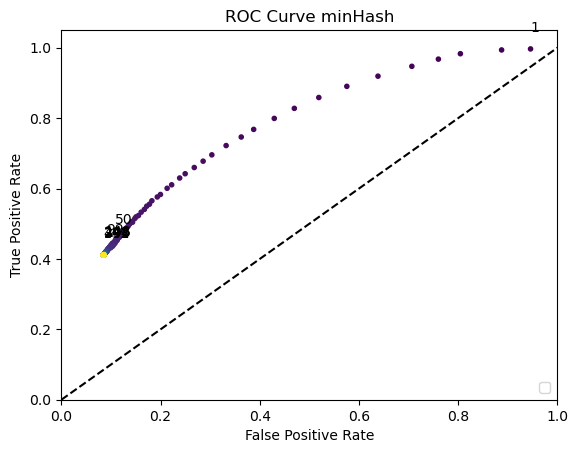

In [64]:
plotROC(minHash_df, "ROC Curve minHash")

## Jaccard in repetitive and non_repetitive regions

In [66]:
minHash_repetitive_df = get_counts_df(minHash_signature_matrix_directory, 
    repetitive = True, build = True)
minHash_non_repetitive_df = get_counts_df(minHash_signature_matrix_directory, 
    non_repetitive = True, build = True)

Save Path	../../../output/analysis/minHash/num_hashes=1000_k=21_repetitive_regions
Building Matrix
Running Parallel Step
Total time	: 75.17275190353394
Save Path	../../../output/analysis/minHash/num_hashes=1000_k=21_non_repetitive_regions
Building Matrix
Running Parallel Step
Total time	: 63.648966789245605


/tmp/ipykernel_1283197/2352464095.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_1283197/2352464095.py:143: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


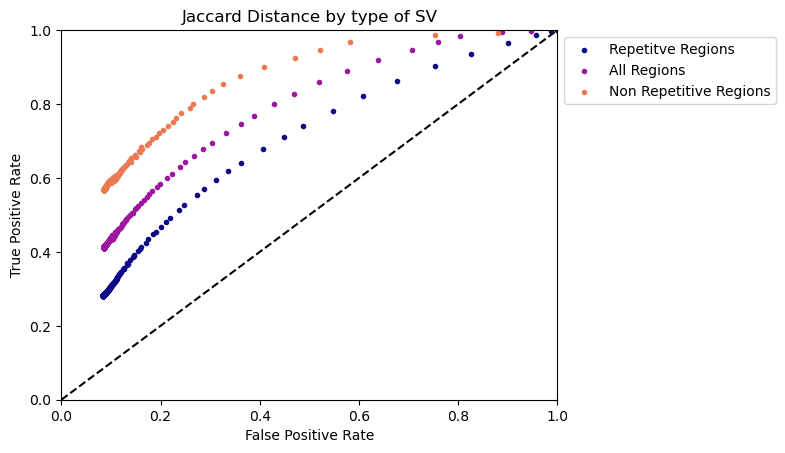

In [67]:
plotROCwithParams(
    (minHash_repetitive_df, minHash_df, minHash_non_repetitive_df),
    ("Repetitve Regions", "All Regions", "Non Repetitive Regions"),
    title = "Jaccard Distance by type of SV", 
    param_header = ""
)

## Jaccard Distance by k

This will take a while to generate but for completeness sake we should run this experiment. We should also run the Jaccard distance for many hashes as well though I don't anticipate that having a significant difference.

## Comparing Filters

/tmp/ipykernel_3892326/2253370976.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_3892326/2253370976.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fprs, tprs,


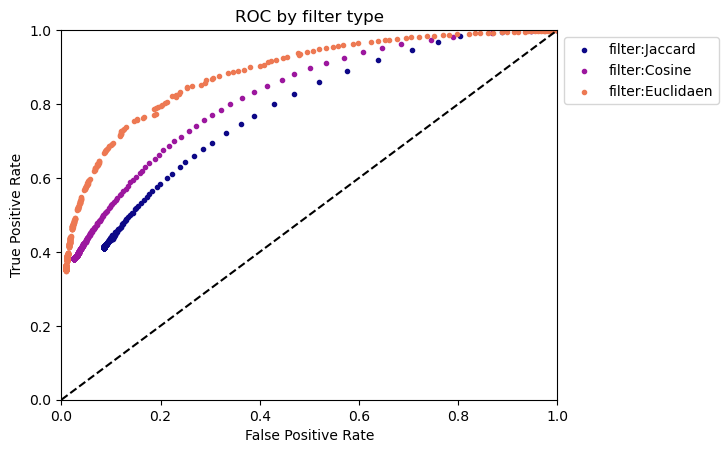

In [30]:
plotROCwithParams(
    (minHash_df, sketch_df, euclidean_df7),
    ("Jaccard", "Cosine", "Euclidaen"),
    title = "ROC by filter type",
    param_header = "filter:"

)